In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ultralytics lapx>=0.5.2

from IPython import display
display.clear_output()

In [ ]:
!pip install supervision

from IPython import display
display.clear_output()

import supervision as sv

In [ ]:
from ultralytics import YOLO
import torch

device ='cuda' if torch.cuda.is_available() else 'cpu'

model = YOLO('yolov8m.pt').to(device)

100%|██████████| 49.7M/49.7M [00:00<00:00, 112MB/s]


In [ ]:
# class_ids of interest - car, motorcycle, bus and truck
# CLASS_ID = [2, 3, 5, 7]
CLASS_ID = [2, 5, 7]

In [ ]:
SOURCE_VIDEO_PATH = '/content/drive/MyDrive/leha1/034.mp4'
TARGET_VIDEO_PATH = '/content/drive/MyDrive/hack/KRA_res_x.mp4'

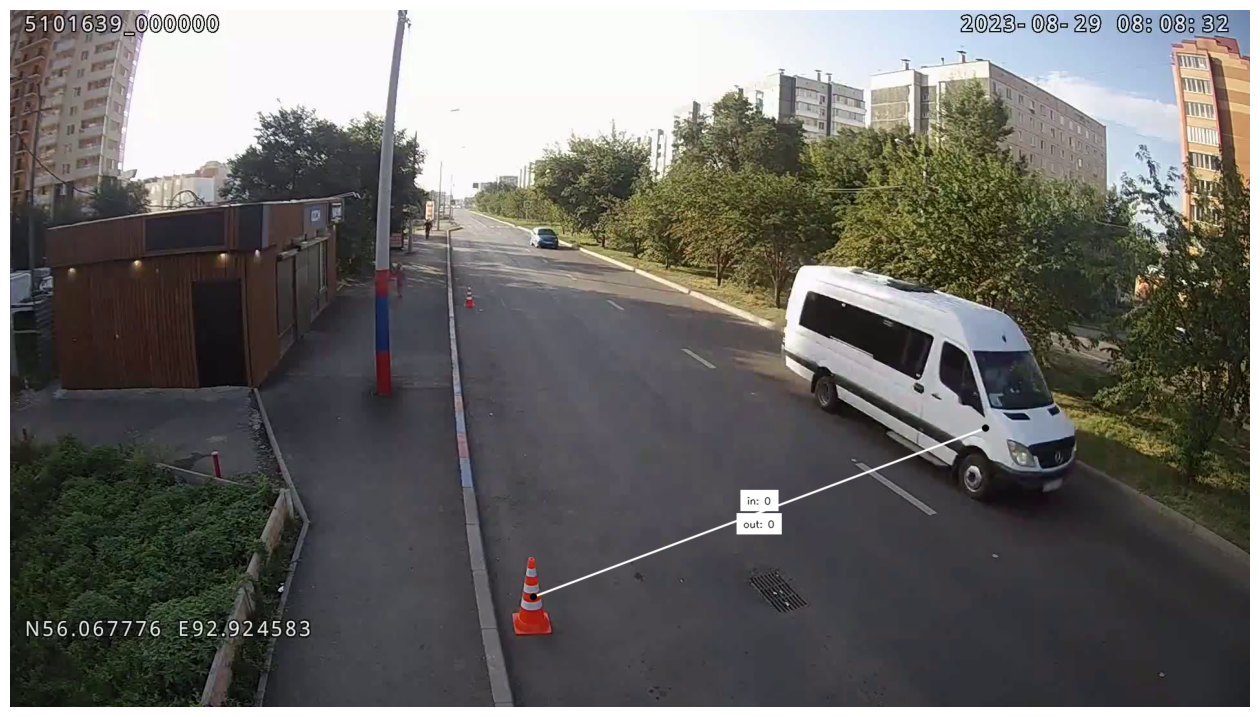

In [ ]:
import numpy as np
import supervision as sv

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
width = video_info.width
height = video_info.height

# initiate polygon zone
polygon = np.array([
    [int(0.3703125 * width), int((0.41388888888888886) * height)],
    [int(0.4979166666666667 * width), int((0.3787037037037037) * height)],
    [int(0.7864583333333334 * width), int((0.6) * height)],
    [int(0.421875 * width ), int((0.8416666666666667) * height)]
])


LINE_START = sv.Point(int(0.421875 * width), int((0.8416666666666667) * height))
LINE_END = sv.Point(int(0.7864583333333334 * width ), int((0.6) * height))

line_counter_bus = sv.LineZone(start=LINE_START, end=LINE_END)
line_annotator = sv.LineZoneAnnotator(thickness=2, text_thickness=1, text_scale=0.5)

zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

# initiate annotators
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=4)

# extract video frame
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)

# detect
results = model(frame)[0]
detections = sv.Detections.from_ultralytics(results)
detections = detections[detections.class_id == 5] # 2/5/7
zone.trigger(detections=detections)

# annotate
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
labels = [f"{model.names[class_id]} {confidence:0.2f}" for _, _, confidence, class_id, _ in detections]
frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)
"""frame = zone_annotator.annotate(scene=frame)
frame = zone_annotator1.annotate(scene=frame)
"""
line_annotator.annotate(frame=frame, line_counter=line_counter_bus)

%matplotlib inline
sv.plot_image(frame, (16, 16))

In [ ]:
def speed_calculation(in_zone_state, polygon_zone, detections, frame_index):
    all_time_zone = 0
    all_objects = 0

    in_zone = polygon_zone.trigger(detections)
    detections_in_zone = detections[in_zone]

    curr_in_zone = set(detections_in_zone.tracker_id)
    prev_in_zone = set(in_zone_state.keys())
    new = curr_in_zone.difference(prev_in_zone) # только заехали в зону
    old = prev_in_zone.difference(curr_in_zone) # только выехали из зоны

    all_objects += len(old)

    # -------------------------------------------------------------

    for tracker_id in new:
        in_zone_state[tracker_id] = frame_index

    for tracker_id in old:
        in_zone_frame_count = frame_index - in_zone_state[tracker_id]
        in_zone_time = in_zone_frame_count * 1 / VIDEO_FPS
        all_time_zone += in_zone_time
        del in_zone_state[tracker_id]

    return all_time_zone, all_objects

In [ ]:
from tqdm.notebook import tqdm
import cv2


# create BYTETracker instance
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

VIDEO_FPS = video_info.fps

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
"""polygon_zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)
polygon_zone1 = sv.PolygonZone(polygon=polygon1, frame_resolution_wh=video_info.resolution_wh)"""

box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
"""zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=4)
zone_annotator1 = sv.PolygonZoneAnnotator(zone=zone1, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=4)"""
line_counter_car = sv.LineZone(start=LINE_START, end=LINE_END)
line_counter_van = sv.LineZone(start=LINE_START, end=LINE_END)
line_counter_bus = sv.LineZone(start=LINE_START, end=LINE_END)
line_annotator = sv.LineZoneAnnotator(thickness=2, text_thickness=1, text_scale=0.5)


zone_car = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

zone_bus = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

zone_van = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)


in_zone_state_car = {} # Dict[int, int]
in_zone_state1_car = {} # Dict[int, int]

in_zone_state_bus = {} # Dict[int, int]
in_zone_state1_bus = {} # Dict[int, int]

in_zone_state_van = {} # Dict[int, int]
in_zone_state1_van = {} # Dict[int, int]

count = 0
DELAY = 3

all_time_car = 0
all_time_bus = 0
all_time_van = 0

all_count_car = 0
all_count_bus = 0
all_count_van = 0

# open target video file
with sv.VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame_index, frame in enumerate(tqdm(generator, total=video_info.total_frames)):
        count += 1
        if count % DELAY != 0:
            continue

        result = model.track(source=frame, agnostic_nms=True, verbose=False, persist=True)[0]
        # frame = result.orig_img
        detections = sv.Detections.from_ultralytics(result)

        if result.boxes.id is not None:
            detections.tracker_id = result.boxes.id.cpu().numpy().astype(int)
        else:
            detections.tracker_id = np.array([])
        try:
            detections_car = detections[detections.class_id == 2]  # car
            detections_bus = detections[detections.class_id == 5]  # bus
            detections_van = detections[detections.class_id == 7]  # van
        except IndexError:
            continue

        """labels = [
            f"{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
            for _, _, confidence, class_id, tracker_id
            in detections
        ]

        frame = box_annotator.annotate(
            scene=frame,
            detections=detections,
            labels=labels
        )"""

        line_counter_car.trigger(detections=detections_car)
        line_counter_van.trigger(detections=detections_van)
        line_counter_bus.trigger(detections=detections_bus)

        """line_annotator.annotate(frame=frame, line_counter=line_counter_car)
        line_annotator.annotate(frame=frame, line_counter=line_counter_van)
        line_annotator.annotate(frame=frame, line_counter=line_counter_bus)"""

        # in_zone_state, polygon_zone, detections, frame_index

        """all_time_car += speed_calculation(in_zone_state_car, zone_car, detections_car, frame_index)
        all_time_car += speed_calculation(in_zone_state1_car, zone1_car, detections_car, frame_index)

        all_time_bus += speed_calculation(in_zone_state_bus, zone_bus, detections_bus, frame_index)
        all_time_bus += speed_calculation(in_zone_state1_bus, zone1_bus, detections_bus, frame_index)

        all_time_van += speed_calculation(in_zone_state_van, zone_van, detections_van, frame_index)
        all_time_van += speed_calculation(in_zone_state1_van, zone1_van, detections_van, frame_index)"""

        # x - время, y - обьекты
        x, y = speed_calculation(in_zone_state_car, zone_car, detections_car, frame_index)

        x2, y2 = speed_calculation(in_zone_state_bus, zone_bus, detections_bus, frame_index)

        x4, y4 = speed_calculation(in_zone_state_van, zone_van, detections_van, frame_index)

        all_time_car += x
        all_time_bus += x2
        all_time_van += x4



        all_count_car += y
        all_count_bus += y2
        all_count_van += y4

        # sink.write_frame(frame)

  0%|          | 0/36000 [00:00<?, ?it/s]

In [ ]:
count_car = line_counter_car.in_count + line_counter_car.out_count

In [ ]:
count_van = line_counter_van.in_count + line_counter_van.out_count

In [ ]:
count_bus = line_counter_bus.in_count + line_counter_bus.out_count

In [ ]:
count_car, count_van, count_bus